Basics of Modeling Sequences and Temporal Convolution Networks



**Problem 1: Kalman Filter**

Apply the Kalman Filter with the given parameters on the provided data.


In [2]:
!pip install bunch
#Import
import sys
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import scipy.io as sio
from bunch import Bunch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils import weight_norm
from os.path import dirname, join as pjoin
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

  Created wheel for bunch: filename=bunch-1.0.1-cp36-none-any.whl size=7075 sha256=7f2d79e80bb2f729a0ba6077e36801b701ca7ce7b21da48a4a2b3d61ed0313ee
  Stored in directory: /root/.cache/pip/wheels/56/0f/19/fbbf81e5764e6d8b74501c4357a88c14c94466ec777c03734c
Successfully built bunch


In [8]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):
        """
        Inputs:
        -------
        F: the state-transition model;
        H: the observation model;
        Q: the covariance of the state-transition noise;
        R: the variance of the observation noise;
        B: the control-input model.

        Output:
        -------
        predict: give the prediction
        update: update the given measured value

        """
        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
        	(I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)


**1(a)**

Try to implement the Kalman Filter on a sample dataset using parameters given below:

*   dt = 1.0/60
*   State transition matrix = 
$$\begin{bmatrix}
1 & dt & 0\\
0 & 1 & dt\\
0 & 0 & 1
\end{bmatrix}$$
*   Observation matrix = $$\begin{bmatrix} 1&0&0.5 \end{bmatrix}$$
*   State-transition covariance = 
$$\begin{bmatrix}
1 & 0.5 & 0\\
0 & 0.84 & 0.23\\
0.1 & 0.6 & 0.2
\end{bmatrix}$$
*   Observation variance = $0.1$








In [9]:
# Your code:
dt = 1.0/60
F = np.array([[1,dt,0],[0,1,dt],[0,0,1]])
H = np.array([[1,0,0.5]]).reshape(1,3)
Q = np.array([[1,0.5,0],[0,0.84,0.23],[0.1,0.6,0.2]])
R = np.array([0.1]).reshape(1,1)

In [10]:
Measured = np.array([-79.0110759 ,  -74.30411423,  -71.79140345,  -70.15579527, 
                     -61.65533322,  -59.51037214,  -57.44834303,  -55.72164108,
                     -51.02031032,  -51.14506435])
kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []

Apply the Kalman Filter to the data

In [11]:
# Your code: 
for z in Measured:
	predictions.append(np.dot(H,  kf.predict())[0])
	kf.update(z)

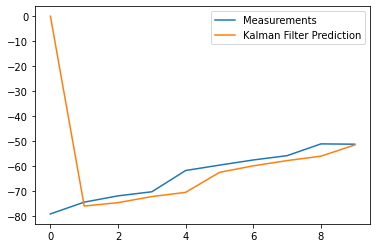

In [12]:
plt.plot(range(len(Measured)), Measured, label = 'Measurements')
plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()

**1(b)**

Assume there is no process error, update your filter parameters and regenerate the plot. Compare to what you get from **1(a)**. What is different? Why?  

In [13]:
# Your code:
R = np.array([1]).reshape(1,1)
kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []
for z in Measured:
	predictions.append(np.dot(H,  kf.predict())[0])
	kf.update(z)

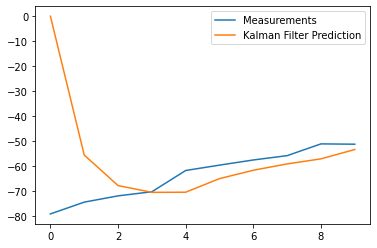

In [14]:
plt.plot(range(len(Measured)), Measured, label = 'Measurements')
plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()

**The model in 1(a) started to follow the trend of measurements immediately after the first prediction, which makes the model a highly accurate one. After the observational variance is increased ten times in the model in 1(b), the model only started to follow the trend of the measurements at the fourth prediction, which makes it less predictive. I think the reason for this change is because the increased observational variance makes the model consider a larger proportion of changes in measurement as variance, thus making the model more conversative about adjusting itself, after which it will be more likely to underfit and less likely to overfit.**

**Problem 2**

In this question, our dataset contains some data sequences: a pair of input sequences and an output. The first sequence within the pair is composed of numbers randomly sampled from the range [0, 1]. The second input sequence within the input sequence pair is composed of only integers: 0 or 1. This sequence must contain only 2 instances of the integer 1; the rest of the integers are all 0s. The output is the sum of the two values from the first input sequence corresponding to 1s in the second input sequence. 

For example, one input sequence pair can be [[0, 0.1, 0.2, 0.3, 0.4, 0.5], [0, 0, 0, 1, 1, 0]]. In this case, the final output value should be 0.3 + 0.4 = 0.7. In this example, the length of the data sequence is 6.

For the detail of TCN, see the GitHub repo [here](https://github.com/locuslab/TCN/tree/master/TCN/adding_problem).

Generate data for training and testing.

In [20]:
def data_generator(N, seq_length):
    """
    Args:
        seq_length: Length of the adding problem data
        N: # of data in the set
    """
    X_num = torch.rand([N, 1, seq_length])
    X_mask = torch.zeros([N, 1, seq_length])
    Y = torch.zeros([N, 1])
    for i in tqdm(range(N)):
        positions = np.random.choice(seq_length, size=2, replace=False)
        X_mask[i, 0, positions[0]] = 1
        X_mask[i, 0, positions[1]] = 1
        Y[i,0] = X_num[i, 0, positions[0]] + X_num[i, 0, positions[1]]
    X = torch.cat((X_num, X_mask), dim=1)
    return Variable(X), Variable(Y)

Initialize training parameters.

In [21]:
args = Bunch()
args.batch_size = 32
args.cuda = True
args.dropout = False
args.clip = -1
args.epochs = 30
args.ksize = 7
args.levels = 8
args.seq_len = 100
args.log_interval = 100
args.lr = 4e-4 ##1e-2
args.optim = 'Adam'
args.nhid = 30
args.seed = 112


Define several classes for training.

In [22]:
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


**2(a)** Build your TCN model below

In [23]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        # Your Code:
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size, 
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

Train your model. You need to use GPU for training here. To start a GPU on your colab, follow the steps below.


Step1:

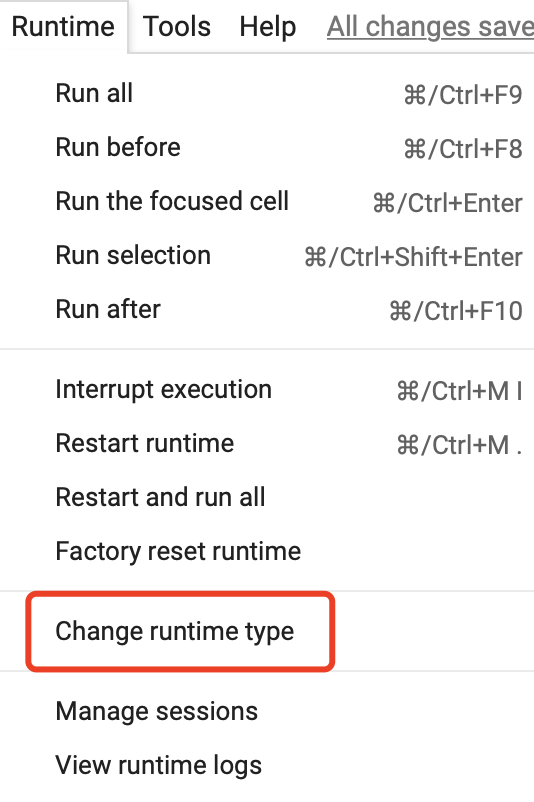

Step2


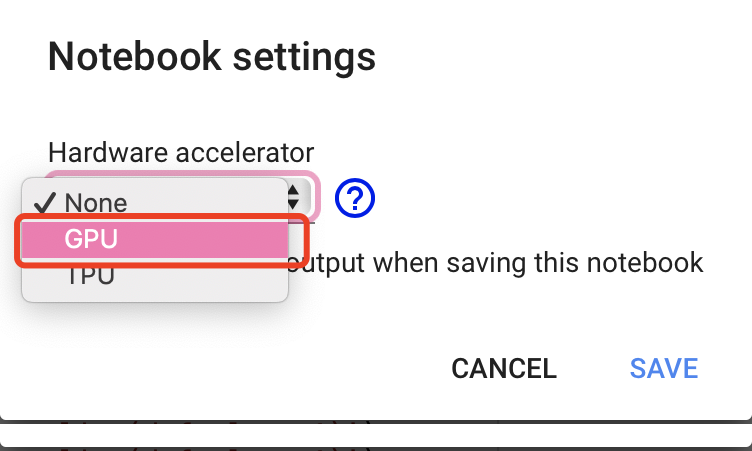

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from bunch import Bunch
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils import weight_norm

torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

input_channels = 2
n_classes = 1
batch_size = args.batch_size
seq_length = args.seq_len
epochs = args.epochs

print(args)
print("Producing data...")
X_train, Y_train = data_generator(5000, seq_length)
X_test, Y_test = data_generator(100, seq_length)


# Note: We use a very simple setting here (assuming all levels have the same # of channels.
channel_sizes = [args.nhid]*args.levels
kernel_size = args.ksize
dropout = args.dropout
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

if args.cuda:
    model.cuda()
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    X_test = X_test.cuda()
    Y_test = Y_test.cuda()

lr = args.lr
optimizer = getattr(optim, args.optim)(model.parameters(), lr=lr)


def train(epoch):
    global lr
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x)
        loss = F.mse_loss(output, y)
        loss.backward()
        if args.clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % args.log_interval == 0:
            cur_loss = total_loss / args.log_interval
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0


def evaluate():
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nValidation set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()


for ep in range(1, epochs+1):
    train(ep)
    tloss = evaluate()

 33%|███▎      | 1651/5000 [00:00<00:00, 16509.90it/s]

batch_size: 32
clip: -1
cuda: true
dropout: false
epochs: 30
ksize: 7
levels: 8
log_interval: 100
lr: 0.0004
nhid: 30
optim: Adam
seed: 112
seq_len: 100

Producing data...


100%|██████████| 100/100 [00:00<00:00, 11200.94it/s]


Train Epoch:  1 [  3168/  5000 (63%)]	Learning rate: 0.0004	Loss: 0.326211

Validation set: Average loss: 0.165078

Train Epoch:  2 [  3168/  5000 (63%)]	Learning rate: 0.0004	Loss: 0.172340

Validation set: Average loss: 0.167915

Train Epoch:  3 [  3168/  5000 (63%)]	Learning rate: 0.0004	Loss: 0.170886

Validation set: Average loss: 0.167368

Train Epoch:  4 [  3168/  5000 (63%)]	Learning rate: 0.0004	Loss: 0.168199

Validation set: Average loss: 0.165383

Train Epoch:  5 [  3168/  5000 (63%)]	Learning rate: 0.0004	Loss: 0.164180

Validation set: Average loss: 0.162475

Train Epoch:  6 [  3168/  5000 (63%)]	Learning rate: 0.0004	Loss: 0.156626

Validation set: Average loss: 0.152685

Train Epoch:  7 [  3168/  5000 (63%)]	Learning rate: 0.0004	Loss: 0.132379

Validation set: Average loss: 0.070007

Train Epoch:  8 [  3168/  5000 (63%)]	Learning rate: 0.0004	Loss: 0.044760

Validation set: Average loss: 0.024329

Train Epoch:  9 [  3168/  5000 (63%)]	Learning rate: 0.0004	Loss: 0.0212

In [ ]:
# Give the test accuracy. We mark the prediction as correct if the prediction is in 
# the interval [label-0.2, label+0.2].
preds = model(X_test)

i = 0
corr = 0
for pred in preds:
    if (pred.data[0]-0.2) <= Y_test[i-1][0] and Y_test[i-1][0]<=(pred.data[0]+0.2):
        corr += 1
        i += 1

print('Test Accuracy:', corr/len(Y_test))

Test Accuracy: 0.15


**2(b)** Show the best result you got by using default training parameters. You only need to give the best and the worst `Average loss` you got here on the validation set, and the `test accuracy`. 

**The worst average lost is 0.167915 while the best average lost is 0.002633, the test accuracy is 0.15.**

**2(c)** Now choose the training parameters by yourself and retrain the model. Please make sure you get better result compare to 2(b). Specify what you changed and why you think that will improve your result. 

In [29]:
# Your code:
args = Bunch()
args.batch_size = 32
args.cuda = True
args.dropout = False
args.clip = -1
args.epochs = 50
args.ksize = 7
args.levels = 8
args.seq_len = 100
args.log_interval = 100
args.lr = 2e-4
args.optim = 'Adam'
args.nhid = 30
args.seed = 112

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size, 
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.conv3 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp3 = Chomp1d(padding)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2,
                                 self.conv3, self.chomp3, self.relu3, self.dropout3)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        self.conv3.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

input_channels = 2
n_classes = 1
batch_size = args.batch_size
seq_length = args.seq_len
epochs = args.epochs

print(args)
print("Producing data...")
X_train, Y_train = data_generator(5000, seq_length)
X_test, Y_test = data_generator(100, seq_length)


# Note: We use a very simple setting here (assuming all levels have the same # of channels.
channel_sizes = [args.nhid]*args.levels
kernel_size = args.ksize
dropout = args.dropout
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

if args.cuda:
    model.cuda()
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    X_test = X_test.cuda()
    Y_test = Y_test.cuda()

lr = args.lr
optimizer = getattr(optim, args.optim)(model.parameters(), lr=lr)


def train(epoch):
    global lr
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x)
        loss = F.mse_loss(output, y)
        loss.backward()
        if args.clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % args.log_interval == 0:
            cur_loss = total_loss / args.log_interval
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0


def evaluate():
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nValidation set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()


for ep in range(1, epochs+1):
    train(ep)
    tloss = evaluate()

 36%|███▌      | 1809/5000 [00:00<00:00, 18083.85it/s]

batch_size: 32
clip: -1
cuda: true
dropout: false
epochs: 50
ksize: 7
levels: 8
log_interval: 100
lr: 0.0002
nhid: 30
optim: Adam
seed: 112
seq_len: 100

Producing data...


100%|██████████| 100/100 [00:00<00:00, 10204.13it/s]


Train Epoch:  1 [  3168/  5000 (63%)]	Learning rate: 0.0002	Loss: 0.562237

Validation set: Average loss: 0.155755

Train Epoch:  2 [  3168/  5000 (63%)]	Learning rate: 0.0002	Loss: 0.163543

Validation set: Average loss: 0.155121

Train Epoch:  3 [  3168/  5000 (63%)]	Learning rate: 0.0002	Loss: 0.162757

Validation set: Average loss: 0.153740

Train Epoch:  4 [  3168/  5000 (63%)]	Learning rate: 0.0002	Loss: 0.160847

Validation set: Average loss: 0.150516

Train Epoch:  5 [  3168/  5000 (63%)]	Learning rate: 0.0002	Loss: 0.156138

Validation set: Average loss: 0.142645

Train Epoch:  6 [  3168/  5000 (63%)]	Learning rate: 0.0002	Loss: 0.146576

Validation set: Average loss: 0.130234

Train Epoch:  7 [  3168/  5000 (63%)]	Learning rate: 0.0002	Loss: 0.113675

Validation set: Average loss: 0.053789

Train Epoch:  8 [  3168/  5000 (63%)]	Learning rate: 0.0002	Loss: 0.054052

Validation set: Average loss: 0.042165

Train Epoch:  9 [  3168/  5000 (63%)]	Learning rate: 0.0002	Loss: 0.0390

In [30]:
preds = model(X_test)

i = 0
corr = 0
for pred in preds:
    if (pred.data[0]-0.2) <= Y_test[i-1][0] and Y_test[i-1][0]<=(pred.data[0]+0.2):
        corr += 1
        i += 1

print('Test Accuracy:', corr/len(Y_test))
# Hint:
# You may want to change 
    # 1. learning rate;
    # 2. training epochs;
    # 3. the number of layers in the network.

Test Accuracy: 0.35


**I have increased the number of training epochs from 30 to 50 and decreased the learning rate from 4e-4 to 2e-4. I have also added an additional layer. The test accuracy was drastically increased after these changes. I believe the additional layer in the model has allowed a more sophisticated function of prediction while the increased epoch number and the decreased learning rate have allowed a finer tuning of the model. These changes combined have enabled more accurate predictions.**


**Problem 3: EEGNet** In this question, we will use EEGNet which is A compact convolutional network for EEG-based brain-computer interfaces. Your task is to process the given eeg data so that you can train and test the network on the dataset. For more detail about the EEGNet, please see the GitHub repo here:
https://github.com/aliasvishnu/EEGNet.

The EEG data given in this question are generated. Feel free to print or plot the data if you want to know what the dataset looks like. 



First, we need to define the EEGNet

In [31]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 120
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 64), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))

        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(4*2*7, 1)
        

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        
        # FC Layer
        x = x.view(-1, 4*2*7)
        x = torch.sigmoid(self.fc1(x))
        return x


net = EEGNet()
print(net.forward(Variable(torch.Tensor(np.random.rand(1, 1, 120, 64)))))
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

tensor([[0.8164]], grad_fn=<SigmoidBackward>)


Define the evaluation function

In [32]:
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 100
    
    predicted = []
    
    for i in range(int(len(X)/batch_size)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted)))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(2*precision*recall/ (precision+recall))
    return results

In [33]:
# MOUNTING GOOGLE DRIVE WHERE DATA IS STORED
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


In [57]:
# Import data and save as np.array
Data = sio.loadmat('/drive/My Drive//X.mat')
Label = sio.loadmat('/drive/My Drive/Y.mat')
Dataset = Data['Data']
Labels = Label['Labels']
print(Dataset.shape, Labels.shape)

(300, 120, 64) (1, 300)


In [59]:
unique_elements, counts_elements = np.unique(Labels.flatten(), return_counts=True)
print(unique_elements, counts_elements)

[0. 1.] [158 142]
(300,)


**3(a)** Now, reshape the data so you can train it using EEGNet. To train the network, you also need to modify the network parameters to match the dimension of your training data. Please see the image [here](https://github.com/aliasvishnu/EEGNet/blob/master/EEGNet.png) for more information. 

In [62]:
 # Your code
Dataset = np.reshape(Dataset, (300,1,120,64))
Labels = np.reshape(Labels, (300))

**3(b)** Print the shape of your data and your label

In [63]:
# Your code:  
print(Dataset.shape, Labels.shape)

(300, 1, 120, 64) (300,)


**3(c)** Now split the training, evaluation, and testing data. Please make sure you have about 80% for training, about 10% for evaluation, and about 10% for testing.

In [64]:
# Your Code: 
# Please name the parameters as names given below in the print function.
X_train = Dataset[0:int(len(Dataset) * 0.8)]
X_test = Dataset[int(len(Dataset) * 0.8):int(len(Dataset) * 0.9)]
X_val = Dataset[int(len(Dataset) * 0.9):int(len(Dataset) * 1)]
y_train = Labels[0:int(len(Labels) * 0.8)]
y_test = Labels[int(len(Labels) * 0.8):int(len(Labels) * 0.9)]
y_val = Labels[int(len(Labels) * 0.9):int(len(Labels) * 1)]

Train and test on your dataset

In [65]:
batch_size = 32

for epoch in range(10):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    running_loss = 0.0
    for i in range(int(len(X_train)/batch_size-1)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.from_numpy(X_train[s:e])
        labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)   
        loss = criterion(outputs, labels)
        loss.backward()
        
        
        optimizer.step()
        
        running_loss += loss.data
    
    # Validation accuracy
    params = ["acc", "auc", "fmeasure"]
    print(params)
    print("Training Loss ", running_loss)
    print("Train - ", evaluate(net, X_train, y_train, params))
    print("Validation - ", evaluate(net, X_val, y_val, params))
    print("Test - ", evaluate(net, X_test, y_test, params))


Epoch  0
['acc', 'auc', 'fmeasure']
Training Loss  tensor(2.9745)
Train -  [0.6916666666666667, 0.7784106696304529, 0.6942148760330579]
Validation -  [0.4, 0.3526785714285714, 0.35714285714285715]
Test -  [0.4, 0.42500000000000004, 0.35714285714285715]

Epoch  1
['acc', 'auc', 'fmeasure']
Training Loss  tensor(3.1814)
Train -  [0.6833333333333333, 0.756599055293137, 0.7054263565891473]
Validation -  [0.5333333333333333, 0.4196428571428571, 0.5]
Test -  [0.4, 0.55, 0.47058823529411764]

Epoch  2
['acc', 'auc', 'fmeasure']
Training Loss  tensor(3.2906)
Train -  [0.6875, 0.7567379827729925, 0.7126436781609196]
Validation -  [0.5333333333333333, 0.4508928571428572, 0.588235294117647]
Test -  [0.4666666666666667, 0.41, 0.42857142857142855]

Epoch  3
['acc', 'auc', 'fmeasure']
Training Loss  tensor(3.1583)
Train -  [0.6958333333333333, 0.7737565990552933, 0.7044534412955465]
Validation -  [0.5, 0.5357142857142857, 0.4827586206896552]
Test -  [0.4, 0.51, 0.4]

Epoch  4
['acc', 'auc', 'fmeasu

**3(d)** Now, splite the data by 50% training, 10% validation, 40% testing. Retrain your model and compare to what you got from 3(c). Do you have better or worse result? Why? 

In [67]:
# Your Code:
# Please name the parameters as names given below in the print function.
X_train = Dataset[0:int(len(Dataset) * 0.5)]
X_test = Dataset[int(len(Dataset) * 0.5):int(len(Dataset) * 0.9)]
X_val = Dataset[int(len(Dataset) * 0.9):int(len(Dataset) * 1)]
y_train = Labels[0:int(len(Labels) * 0.5)]
y_test = Labels[int(len(Labels) * 0.5):int(len(Labels) * 0.9)]
y_val = Labels[int(len(Labels) * 0.9):int(len(Labels) * 1)]

batch_size = 32

for epoch in range(10):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    running_loss = 0.0
    for i in range(int(len(X_train)/batch_size-1)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.from_numpy(X_train[s:e])
        labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)   
        loss = criterion(outputs, labels)
        loss.backward()
        
        
        optimizer.step()
        
        running_loss += loss.data
    
    # Validation accuracy
    params = ["acc", "auc", "fmeasure"]
    print(params)
    print("Training Loss ", running_loss)
    print("Train - ", evaluate(net, X_train, y_train, params))
    print("Validation - ", evaluate(net, X_val, y_val, params))
    print("Test - ", evaluate(net, X_test, y_test, params))

print(X_train.shape, X_val.shape,X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


Epoch  0
['acc', 'auc', 'fmeasure']
Training Loss  tensor(1.4558)
Train -  [0.82, 0.9125, 0.8301886792452831]
Validation -  [0.5, 0.4642857142857143, 0.4827586206896552]
Test -  [0.6166666666666667, 0.6750578703703705, 0.6166666666666666]

Epoch  1
['acc', 'auc', 'fmeasure']
Training Loss  tensor(1.4425)
Train -  [0.7933333333333333, 0.8773214285714286, 0.8098159509202455]
Validation -  [0.4666666666666667, 0.4375, 0.4666666666666667]
Test -  [0.6583333333333333, 0.6692708333333334, 0.6238532110091743]

Epoch  2
['acc', 'auc', 'fmeasure']
Training Loss  tensor(1.3214)
Train -  [0.8266666666666667, 0.8973214285714285, 0.8395061728395061]
Validation -  [0.36666666666666664, 0.34375, 0.3448275862068965]
Test -  [0.6166666666666667, 0.6414930555555556, 0.5740740740740741]

Epoch  3
['acc', 'auc', 'fmeasure']
Training Loss  tensor(1.2301)
Train -  [0.8266666666666667, 0.8887499999999999, 0.8452380952380951]
Validation -  [0.6333333333333333, 0.6205357142857143, 0.6206896551724138]
Test -  

**Compared to the previous model (at Epoch 9), the modified model with less training set and more testing set has demonstrated an increased accuracy in training but a decreased accuracy in testing, which makes the model a worse model. I believe the reason behind this change is that with a smaller training set and a small validation set, it is hard for the model to prevent overfitting. The additional overfitting has caused the model to be less able to accurately predict the data in the testing set.**